In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u

In [22]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
print("read icdata")
f.close()
file = filenames[0]
f = open(os.path.join(t_eff_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
uptdata = []
for file in filenames:
    content = []
    f = open(os.path.join(t_eff_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column)
    temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    uptdata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()

read icdata
IC40_exp.csv read
IC59_exp.csv read
IC79_exp.csv read
IC86_I_exp.csv read
IC86_II_exp.csv read
IC86_III_exp.csv read
IC86_IV_exp.csv read
IC86_V_exp.csv read
IC86_VI_exp.csv read
IC86_VII_exp.csv read


In [31]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
print(np.sum(icwidths))

1134450


In [38]:
ictimes = icdata['MJD[days]'].values
icparts = [np.sum(icwidths[:i]) for i in range(1,len(icwidths)+1)]
icparts

[0,
 36900,
 143911,
 237044,
 373288,
 486146,
 608687,
 735732,
 865043,
 988700,
 1134450]

In [ ]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)

In [ ]:
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


In [ ]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
global p, lg
p = len(msra)
lg = len(icra) // p + 1
#cut = 20
#cone = 3
#psrno = 0

In [ ]:
[min(msdec), max(msdec)]

[-83.298894, 86.720335]

In [ ]:
icra[[0, 6, 8] ]

array([203.024, 147.017, 236.214])

In [ ]:
def hvovec(lon1, lat1, lon2, lat2, rad=False):

    f'''
    Returns the haversine angle between two vectors given their latitude and longitude
    {rad} = True -> Angle is returned in radians
    {rad} = False (default) -> Angle is returned in Degrees

    #NOTE:
        This function assumes the input to be in degrees and of equal length
    '''

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    if rad == True:
        return np.arccos(a)
    else:
        return np.abs(np.rad2deg(np.arccos(a)))


def angdecfinder(psrno, declcut):

    f'''
    Returns the absolute difference between the declinations of pulsar  {psrno}
    and each of the neutrinos within the specified declcut
    '''

    #aang = hvovec(msra[psrno], msdec[psrno], icra, icdec)
    decdf = list(np.abs(np.subtract(icdec, msdec[psrno])))
    nuind = []
    for i in range(0, len(decdf)):
        if decdf[i] < declcut:
            nuind.append(i)
            #decdf.pop(i)
            #aang[i] = -1
    fdecdf = list(np.abs(np.subtract(icdec[nuind], msdec[psrno])))
    return [nuind, decdf]

def S_ij(psrno, nuind): 

    f'''
    Returns the signal PDF for the {psrno}th pulsar 
    and the all neutrinos within the specified declcut as given in {nuind}
    '''

    ang2 = hvovec(msra[psrno], msdec[psrno], icra[nuind], icdec[nuind], rad=True) ** 2
    sg = np.deg2rad(icang[nuind]) ** 2
    return np.exp(-1 * ang2 / (2 * sg)) / (2 * np.pi * sg)

def bgs(psrno, cone, twopi = False):

    f'''
    Returns the background PDF for a given pulsar {psrno} within 
    a cone of {cone} degrees for SINGLE STACKED ANALYSIS
    '''

    if twopi == True:
        s_ang = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))*(2 * np.pi)
        return 1/s_ang
    else:
        s_ang = (np.sin(np.deg2rad(msdec[psrno] + cone)) - np.sin(np.deg2rad(msdec[psrno] - cone)))
        return 1/s_ang

def Pr(x, Ns, S, B):

    '''
    Returns the probability of the selected set of neutrinos being associated with a given pulsar
    with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


def TS(i, x, S, B, Ns):

    f'''Returns the Test Stastic value fot {i}^th grb
    at $n_s$ = {x} for its parameters S, B, Ns    '''
    
    return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))


def ns_for_TSmax(i, S, B, Ns):

    f'''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS(i,x, S, B, Ns)
    soln = minimize(nll, 3 ,bounds=((0,None),))
    ns = float(soln.x)
    return ns


In [ ]:
def singpsr(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_ij(psrno, nuind)
    B = bgs(psrno, cone, True)
    Ns = len(nuind)
    maxns = ns_for_TSmax(psrno, S, B, Ns)
    return [maxns, np.sqrt(TS(psrno, maxns, S, B, Ns))]

tsmax = []
errpsr = []
pool = mul.Pool(8, maxtasksperchild=800)
op_async = pool.map_async(singpsr, range(p))
tsmax = op_async.get()
op_async = []
pool = []
'''
for i in range(p):
    #try:
    tsmax.append(singpsr2(i))
    #except TypeError:
     #   errpsr.append(i)'''
maxns = []
sqrtts = []
for i in tsmax:
    maxns.append(i[0])
    sqrtts.append(i[1])



sqrtt = np.sqrt(sqrtts)

np.argmax(sqrtt)

In [ ]:
psrno = 0
cut = 5
cone = 5
nuind, decdf = angdecfinder(psrno, cut)
S = S_ij(psrno, nuind)
B = bgs(psrno, cone, True)
Ns = len(nuind)
maxns = ns_for_TSmax(psrno, S, B, Ns)

In [ ]:
len(S)

38525

In [ ]:
singpsr(971)

[0.0, 0.0]

38855


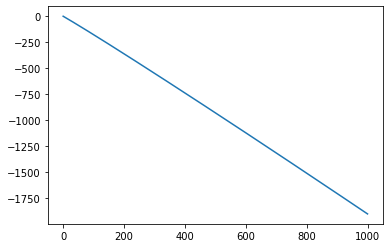

[0.0, 0.0]


In [ ]:
def plotpsr(psrno):
    cut = 5
    cone = 5
    nuind, decdf = angdecfinder(psrno, cut)
    S = S_ij(psrno, nuind)
    B = bgs(psrno, cone)
    Ns = len(nuind)
    tns=[TS(psrno, i, S, B, Ns) for i in range(0, 1000)]
    print(Ns)
    plt.plot(range(0, 1000), tns)
    plt.show()
    print([ns_for_TSmax(psrno, S, B, Ns), TS(psrno, ns_for_TSmax(psrno, S, B, Ns), S, B, Ns)])
plotpsr(971)

In [ ]:
def psrcustom(arr):
    cut = 5
    cone = 5
    for psrno in arr:
        nearcrd=[]
        for i in range(len(icdec)):
            if abs(icdec[i] - msdec[psrno]) <= cut:
                nearcrd.append([icra[i], icdec[i], icang[i]])
        print([psrno, msra[psrno], msdec[psrno]])
        np.savetxt(f"outputs/ndecnear{psrno}.txt", nearcrd)
        print("len(nearcrd) = ", len(nearcrd))

psrcustom([971])

[971, 228.43658, -59.77553]
len(nearcrd) =  38855
